Paul Giesting, Project 2

### The final notebook?

Bring in hitting/speed/small ball data, pitching data, fielding data, attendance data.

##### Multiple strategies:

##### Atemporal regression.
Do a standard randomized split on the data.
Train up a polynomial, degree 2 LASSO model on selected parameters from visualizations.
Test model to see if it holds water.
Look at coefficients & suggest interventions to reverse attendance declines.

##### Time series.
Split data into 20th & 21st century, train & test.
Train up a similar model.
See how much adding the time factor adds to the fit (representing external cultural changes).
Change train / test splits as needed.
Project the 2020s with various rules / culture interventions.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [5]:
with open('bat_rate_data.pkl','rb') as cellar:
    bat_df = pickle.load(cellar)
with open('pitch_rate_data.pkl','rb') as cellar:
    pitch_df = pickle.load(cellar)
with open('field_rate_data.pkl','rb') as cellar:
    field_df = pickle.load(cellar)
# with open('sp.pkl','rb') as cellar:
#    sp_df = pickle.load(cellar)
# with open('sb.pkl','rb') as cellar:
#    sb_df = pickle.load(cellar)
with open('att.pkl','rb') as cellar:
    att_df = pickle.load(cellar)

###### Target:
* NormAtt/G * 1000000 (or Att)
= attendance per game in units of parts per million of the U.S. population (using ppm because as a fraction it's really small and seaborn actually gagged on it in some of the pairplots & treated it as zero); the calculation was already done in the visualization notebooks

###### Flagship parameters for model:
* BA, SLG, HR/G, 'SB/G', SH/G, SO9, ERA, DefEff, GmDur

###### "On-deck" parameters:
* IBB/G, 'CS/G', '3B/G', SF/G, DP/G, A/G, Fld% 

In [7]:
bat_df.columns

Index(['Year', 'G', 'R/G', 'PA/G', 'AB/G', 'H/G', '2B/G', '3B/G', 'HR/G',
       'RBI/G', 'SB/G', 'CS/G', 'BB/G', 'SO/G', 'BA', 'OBP', 'SLG', 'OPS',
       'OPS+', 'TB/G', 'GDP/G', 'HBP/G', 'SH/G', 'SF/G', 'IBB/G', 'LOB/G'],
      dtype='object')

In [8]:
pitch_df.columns

Index(['Year', 'ERA', 'HR9', 'BB9', 'SO9', 'SO/W', 'WHIP', 'Att'], dtype='object')

In [9]:
field_df.columns

Index(['Year', 'RA/G', 'DefEff', 'Fld%', 'DP/G', 'PO/G', 'A/G', 'Att'], dtype='object')

In [10]:
att_df.columns

Index(['Year', 'ASG Ratings', 'WS Ratings', 'Pitches/PA', 'Pitchers/G',
       'GmDur', 'NormAtt/G'],
      dtype='object')

In [11]:
# rewrite this as train_test
y = pitch_df['Att']
X1 = [bat_df['BA'],bat_df['SLG'],bat_df['HR/G'],
     bat_df['SB/G'],bat_df['SH/G'],pitch_df['SO9'],
     pitch_df['ERA'],field_df['DefEff'],att_df['GmDur']]
X2 = [bat_df['IBB/G'],bat_df['CS/G'],bat_df['3B/G'],
     bat_df['SF/G'],field_df['DP/G'],field_df['A/G'],
     field_df['Fld%']]

In [68]:
X = pd.concat([X1,X2,att_df['Pitchers/G']],axis=1)
X.head()

,BA,SLG,HR/G,SB/G,SH/G,SO9,ERA,DefEff,GmDur,IBB/G,CS/G,3B/G,SF/G,DP/G,A/G,Fld%,Pitchers/G
1901,0.272,0.360,0.201439,1.280576,0.755396,3.2,3.49,0.661,0.0,0.0,0.0,0.553957,0.0,0.690647,12.992806,0.943,NaN
1902,0.267,0.344,0.157143,1.200000,0.821429,3.0,3.17,0.673,0.0,0.0,0.0,0.435714,0.0,0.707143,13.150000,0.949,NaN
1903,0.262,0.346,0.151079,1.230216,0.906475,3.6,3.11,0.672,0.0,0.0,0.0,0.525180,0.0,0.633094,13.021583,0.949,NaN
1904,0.247,0.321,0.134615,1.115385,0.891026,3.8,2.66,0.691,0.0,0.0,0.0,0.461538,0.0,0.557692,13.141026,0.955,NaN
1905,0.248,0.323,0.135484,1.187097,1.012903,3.9,2.82,0.690,0.0,0.0,0.0,0.451613,0.0,0.580645,12.961290,0.956,NaN


In [69]:
X2s = pd.concat([X['BA'],X['HR/G'],X['SO9'],X['Pitchers/G'],
                X['3B/G'],X['SH/G'],X['Fld%']],axis=1)
X2s['SO9^2'] = X2s['SO9']**2
X2s['PitG^2'] = X2s['Pitchers/G']**2
X2s['3B^2'] = X2s['3B/G']**2
X2s['SH^2'] = X2s['SH/G']**2
X2s['Fld^2'] = X2s['Fld%']**2
X2s = X2s.loc[1920:2019]

In [70]:
y = y.loc[1920:2019]

In [71]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     22.91
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           5.54e-22
Time:                        22:28:29   Log-Likelihood:                -365.98
No. Observations:                 100   AIC:                             758.0
Df Residuals:                      87   BIC:                             791.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.021e+04    1.3e+05      0.232      0.8

In [72]:
del X2s['Fld%']

In [73]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     25.26
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           1.10e-22
Time:                        22:29:24   Log-Likelihood:                -366.01
No. Observations:                 100   AIC:                             756.0
Df Residuals:                      88   BIC:                             787.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1618.7427    655.669     -2.469      0.0

In [74]:
del X2s['3B/G']

In [75]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     28.04
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           2.17e-23
Time:                        22:30:01   Log-Likelihood:                -366.10
No. Observations:                 100   AIC:                             754.2
Df Residuals:                      89   BIC:                             782.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1669.5179    639.976     -2.609      0.0

In [76]:
del X2s['BA']

In [77]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     31.04
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           6.10e-24
Time:                        22:30:21   Log-Likelihood:                -366.66
No. Observations:                 100   AIC:                             753.3
Df Residuals:                      90   BIC:                             779.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2009.9890    541.517     -3.712      0.0

In [78]:
del X2s['HR/G']

In [79]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     35.03
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           1.29e-24
Time:                        22:30:53   Log-Likelihood:                -366.96
No. Observations:                 100   AIC:                             751.9
Df Residuals:                      91   BIC:                             775.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2023.9358    539.813     -3.749      0.0

In [80]:
del X2s['SH/G']

In [81]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     39.51
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           4.41e-25
Time:                        22:31:24   Log-Likelihood:                -367.86
No. Observations:                 100   AIC:                             751.7
Df Residuals:                      92   BIC:                             772.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2146.5574    533.281     -4.025      0.0

In [82]:
del X2s['SH^2']

In [83]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     45.62
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           1.28e-25
Time:                        22:31:48   Log-Likelihood:                -368.66
No. Observations:                 100   AIC:                             751.3
Df Residuals:                      93   BIC:                             769.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2124.2566    534.344     -3.975      0.0

This is a good branch point.

In [91]:
X2f = X2s.copy()
del X2f['SO9^2']

In [92]:
sm_atemp = sm.OLS(y,sm.add_constant(X2f))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     52.90
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           7.65e-26
Time:                        22:37:17   Log-Likelihood:                -370.33
No. Observations:                 100   AIC:                             752.7
Df Residuals:                      94   BIC:                             768.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2095.5073    540.163     -3.879      0.0

In [93]:
X2f.corr()

,SO9,Pitchers/G,PitG^2,3B^2,Fld^2
SO9,1.000000,0.951166,0.928689,-0.819113,0.932918
Pitchers/G,0.951166,1.000000,0.993577,-0.727325,0.920305
PitG^2,0.928689,0.993577,1.000000,-0.666176,0.881051
3B^2,-0.819113,-0.727325,-0.666176,1.000000,-0.902349
Fld^2,0.932918,0.920305,0.881051,-0.902349,1.000000


In [94]:
del X2f['Pitchers/G']

In [95]:
sm_atemp = sm.OLS(y,sm.add_constant(X2f))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     45.80
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           2.20e-21
Time:                        22:37:59   Log-Likelihood:                -383.53
No. Observations:                 100   AIC:                             777.1
Df Residuals:                      95   BIC:                             790.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3492.4670    536.200     -6.513      0.0

In [96]:
del X2f['PitG^2']

In [97]:
sm_atemp = sm.OLS(y,sm.add_constant(X2f))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     61.53
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           2.81e-22
Time:                        22:38:36   Log-Likelihood:                -383.63
No. Observations:                 100   AIC:                             775.3
Df Residuals:                      96   BIC:                             785.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3349.1129    417.257     -8.026      0.0

I deleted one of the forks. This is a second. Let's go back to Lasso and start at my branch point and let Lasso do the thinking.

In [98]:
output = []
for i in range(10):
    Xptr, Xpv, yptr, ypv = train_test_split(X2s, y, test_size=0.2)
    Xpsc = scaler.fit_transform(Xptr.values)
    Xpvsc = scaler.fit_transform(Xpv.values)
    lasso_atemp = LassoCV()
    lasso_atemp.fit(Xpsc,yptr)
    out = pd.DataFrame(lasso_atemp.coef_,index=X2s.columns).round(decimals=2)
    out = out.transpose()
    out['TrSc'] = lasso_atemp.score(Xpsc,yptr)
    out['VSc'] = lasso_atemp.score(Xpvsc,ypv)
    out = out.transpose()
    out.columns = [i]
    output.append(out.round(decimals=2))
out_df = pd.concat(output,axis=1)

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.015320401982535, tolerance: 2.429097704644798
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.5874814214867, tolerance: 2.429097704644798
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Object

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.342959800014796, tolerance: 2.4847919692236315
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.611649010365, tolerance: 2.4847919692236315
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.841532811396974, tolerance: 2.4847919692236315
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: O

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.187463237428346, tolerance: 2.5625135299517323
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.112778681707823, tolerance: 2.5625135299517323
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.724634782699468, tolerance: 2.5625135299517323
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.434659031008778, tolerance: 2.5492620019411376
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.30782055785585, tolerance: 2.5492620019411376
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.63457277453108, tolerance: 2.5492620019411376
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: 

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.205321949776135, tolerance: 2.170426158593873
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.73227962584133, tolerance: 2.449269597651724
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.125432038648796, tolerance: 2.449269597651724
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Ob

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.49841144622678, tolerance: 2.347006230397824
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.354590795060176, tolerance: 2.347006230397824
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.265772422203554, tolerance: 2.347006230397824
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Ob

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.38802129927626, tolerance: 2.3807734978710355
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.71008507901024, tolerance: 2.3807734978710355
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.79066363695529, tolerance: 2.3807734978710355
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: O

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2098.1091195394642, tolerance: 2.824530340813517
  positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.229818329864429, tolerance: 2.058600721618985
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not conve

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.8854225139512, tolerance: 2.4376475864571425
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.764676775343105, tolerance: 2.4376475864571425
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.18455930475102, tolerance: 2.4376475864571425
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: O

In [99]:
out_df

,0,1,2,3,4,5,6,7,8,9
SO9,-3.34,-8.14,-2.37,-20.51,-27.06,1.06,5.76,-11.38,-0.99,3.54
Pitchers/G,58.46,61.15,60.61,87.75,74.83,75.75,55.34,72.74,63.47,65.43
SO9^2,-13.54,-7.29,-7.57,1.67,5.33,-21.02,-19.20,-7.10,-14.50,-20.68
PitG^2,-43.68,-47.92,-52.54,-71.16,-60.40,-54.44,-40.14,-56.15,-46.54,-46.37
3B^2,12.11,10.89,13.90,9.89,9.39,10.88,11.04,11.53,9.48,11.01
Fld^2,24.25,23.97,27.92,24.32,27.75,20.31,20.70,23.84,18.04,20.47
TrSc,0.74,0.70,0.76,0.75,0.81,0.72,0.73,0.72,0.74,0.73
VSc,0.52,0.87,0.36,0.59,0.40,0.71,0.69,0.72,0.61,0.65


Lasso agrees that strikeouts are problematic. Let's try SO9 linear this time.

In [100]:
X2l = X2s.copy()
del X2l['SO9']

In [101]:
output = []
for i in range(10):
    Xptr, Xpv, yptr, ypv = train_test_split(X2l, y, test_size=0.2)
    Xpsc = scaler.fit_transform(Xptr.values)
    Xpvsc = scaler.fit_transform(Xpv.values)
    lasso_atemp = LassoCV()
    lasso_atemp.fit(Xpsc,yptr)
    out = pd.DataFrame(lasso_atemp.coef_,index=X2l.columns).round(decimals=2)
    out = out.transpose()
    out['TrSc'] = lasso_atemp.score(Xpsc,yptr)
    out['VSc'] = lasso_atemp.score(Xpvsc,ypv)
    out = out.transpose()
    out.columns = [i]
    output.append(out.round(decimals=2))
out_df = pd.concat(output,axis=1)

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.2134359330039, tolerance: 2.8862027302849618
  positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converg

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.186157192966675, tolerance: 3.147761499532811
  positive)


In [102]:
out_df

,0,1,2,3,4,5,6,7,8,9
Pitchers/G,66.43,63.13,62.35,57.68,60.37,62.16,46.08,61.74,66.41,58.79
SO9^2,-17.91,-17.66,-14.35,-12.91,-17.89,-16.58,-18.89,-16.08,-16.23,-14.81
PitG^2,-48.11,-47.31,-44.91,-45.53,-42.31,-46.06,-28.68,-44.97,-49.25,-45.15
3B^2,10.51,11.83,9.35,11.49,9.76,9.28,7.66,10.52,9.10,10.79
Fld^2,21.15,24.50,17.20,24.17,19.89,21.78,20.21,21.19,18.37,23.53
TrSc,0.77,0.74,0.75,0.74,0.68,0.72,0.69,0.72,0.69,0.76
VSc,0.56,0.63,0.65,0.62,0.79,0.71,0.79,0.50,0.77,0.63


In [105]:
out_df['sigma']=out_df.apply(np.std,axis=1)

In [106]:
out_df

,0,1,2,3,4,5,6,7,8,9,sigma
Pitchers/G,66.43,63.13,62.35,57.68,60.37,62.16,46.08,61.74,66.41,58.79,5.509568
SO9^2,-17.91,-17.66,-14.35,-12.91,-17.89,-16.58,-18.89,-16.08,-16.23,-14.81,1.769596
PitG^2,-48.11,-47.31,-44.91,-45.53,-42.31,-46.06,-28.68,-44.97,-49.25,-45.15,5.496593
3B^2,10.51,11.83,9.35,11.49,9.76,9.28,7.66,10.52,9.10,10.79,1.183186
Fld^2,21.15,24.50,17.20,24.17,19.89,21.78,20.21,21.19,18.37,23.53,2.284379
TrSc,0.77,0.74,0.75,0.74,0.68,0.72,0.69,0.72,0.69,0.76,0.029732
VSc,0.56,0.63,0.65,0.62,0.79,0.71,0.79,0.50,0.77,0.63,0.093408


In [107]:
betas = out_df[5].transpose()
betas

Pitchers/G    62.16
SO9^2        -16.58
PitG^2       -46.06
3B^2           9.28
Fld^2         21.78
TrSc           0.72
VSc            0.71
Name: 5, dtype: float64

Hmmm. This isn't very actionable. I'm going to be optimistic and proceed with the hunch that there are several hidden variables here, and I can simply choose to pick the most actionable ones. Let me see what Lasso says if I knock out SO9^2 instead of SO9.

Fourth tine of the fork.

In [108]:
X2l = X2s.copy()
del X2l['SO9^2']

In [109]:
output = []
for i in range(10):
    Xptr, Xpv, yptr, ypv = train_test_split(X2l, y, test_size=0.2)
    Xpsc = scaler.fit_transform(Xptr.values)
    Xpvsc = scaler.fit_transform(Xpv.values)
    lasso_atemp = LassoCV()
    lasso_atemp.fit(Xpsc,yptr)
    out = pd.DataFrame(lasso_atemp.coef_,index=X2l.columns).round(decimals=2)
    out = out.transpose()
    out['TrSc'] = lasso_atemp.score(Xpsc,yptr)
    out['VSc'] = lasso_atemp.score(Xpvsc,ypv)
    out = out.transpose()
    out.columns = [i]
    output.append(out.round(decimals=2))
out_df = pd.concat(output,axis=1)

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.9534434947409, tolerance: 2.6368284070044363
  positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converg

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333.4179677320235, tolerance: 2.8381810287217997
  positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147.64452676542442, tolerance: 2.690392053181643
  positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 

In [110]:
out_df

,0,1,2,3,4,5,6,7,8,9
SO9,-16.55,-15.53,-17.04,-17.82,-17.92,-16.74,-18.55,-17.57,-17.60,-14.14
Pitchers/G,88.07,89.14,104.63,90.48,92.44,80.10,78.27,80.97,93.78,87.25
PitG^2,-69.79,-71.80,-83.36,-72.20,-70.21,-62.29,-62.00,-64.35,-75.51,-69.66
3B^2,7.81,10.80,11.00,11.56,5.84,9.56,10.46,10.79,7.87,9.31
Fld^2,16.94,19.26,17.32,20.86,12.89,18.51,22.81,22.03,18.05,17.53
TrSc,0.76,0.70,0.79,0.74,0.72,0.69,0.71,0.70,0.75,0.74
VSc,0.66,0.79,0.63,0.57,0.78,0.74,0.70,0.85,0.40,0.59


In [111]:
X2l.corr()

,SO9,Pitchers/G,PitG^2,3B^2,Fld^2
SO9,1.000000,0.951166,0.928689,-0.819113,0.932918
Pitchers/G,0.951166,1.000000,0.993577,-0.727325,0.920305
PitG^2,0.928689,0.993577,1.000000,-0.666176,0.881051
3B^2,-0.819113,-0.727325,-0.666176,1.000000,-0.902349
Fld^2,0.932918,0.920305,0.881051,-0.902349,1.000000


I should be pretty fearless about knocking out pitchers / game. That adjustment is already being made.

In [112]:
del X2l['Pitchers/G']

In [113]:
output = []
for i in range(10):
    Xptr, Xpv, yptr, ypv = train_test_split(X2l, y, test_size=0.2)
    Xpsc = scaler.fit_transform(Xptr.values)
    Xpvsc = scaler.fit_transform(Xpv.values)
    lasso_atemp = LassoCV()
    lasso_atemp.fit(Xpsc,yptr)
    out = pd.DataFrame(lasso_atemp.coef_,index=X2l.columns).round(decimals=2)
    out = out.transpose()
    out['TrSc'] = lasso_atemp.score(Xpsc,yptr)
    out['VSc'] = lasso_atemp.score(Xpvsc,ypv)
    out = out.transpose()
    out.columns = [i]
    output.append(out.round(decimals=2))
out_df = pd.concat(output,axis=1)

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A colu

In [114]:
out_df

,0,1,2,3,4,5,6,7,8,9
SO9,-9.42,-13.81,-9.46,-10.99,-8.81,-12.58,-12.74,-10.48,-9.03,-11.18
PitG^2,-0.00,-0.00,-0.00,-0.00,-6.17,0.00,-2.07,-0.02,0.31,-2.31
3B^2,10.05,6.53,9.13,8.35,12.85,7.23,9.25,8.90,5.86,11.85
Fld^2,32.46,32.86,32.25,31.92,40.36,33.26,35.99,32.49,27.44,37.39
TrSc,0.67,0.68,0.66,0.64,0.66,0.71,0.65,0.67,0.63,0.68
VSc,0.56,0.49,0.63,0.68,0.46,0.36,0.63,0.62,0.64,0.60


In [115]:
del X2l['PitG^2']

In [116]:
output = []
for i in range(10):
    Xptr, Xpv, yptr, ypv = train_test_split(X2l, y, test_size=0.2)
    Xpsc = scaler.fit_transform(Xptr.values)
    Xpvsc = scaler.fit_transform(Xpv.values)
    lasso_atemp = LassoCV()
    lasso_atemp.fit(Xpsc,yptr)
    out = pd.DataFrame(lasso_atemp.coef_,index=X2l.columns).round(decimals=2)
    out = out.transpose()
    out['TrSc'] = lasso_atemp.score(Xpsc,yptr)
    out['VSc'] = lasso_atemp.score(Xpvsc,ypv)
    out = out.transpose()
    out.columns = [i]
    output.append(out.round(decimals=2))
out_df = pd.concat(output,axis=1)

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A colu

In [117]:
out_df

,0,1,2,3,4,5,6,7,8,9
SO9,-8.90,-9.98,-13.89,-13.15,-10.71,-10.89,-11.31,-12.39,-9.78,-14.47
3B^2,10.84,9.79,11.55,8.61,9.77,7.84,8.79,8.84,9.34,10.22
Fld^2,32.65,32.69,36.96,34.68,32.76,31.65,33.81,34.32,32.24,35.96
TrSc,0.64,0.67,0.64,0.67,0.66,0.66,0.67,0.68,0.68,0.68
VSc,0.55,0.00,0.74,0.58,0.62,0.65,0.49,0.58,0.56,0.58


Hmmm. I recognize this model.

In [118]:
lin_atemp = LinearRegression()
lin_atemp.fit(X2l,y)
lin_atemp.score(X2l,y)

0.6578718695423985

Just for completeness, let me recover the first tine.

In [119]:
X2f = X2s.copy()
del X2f['SO9^2']

In [120]:
sm_atemp = sm.OLS(y,sm.add_constant(X2f))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     52.90
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           7.65e-26
Time:                        23:07:08   Log-Likelihood:                -370.33
No. Observations:                 100   AIC:                             752.7
Df Residuals:                      94   BIC:                             768.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2095.5073    540.163     -3.879      0.0

In [121]:
del X2f['Fld^2']

In [122]:
sm_atemp = sm.OLS(y,sm.add_constant(X2f))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     55.69
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           4.23e-24
Time:                        23:08:03   Log-Likelihood:                -376.89
No. Observations:                 100   AIC:                             763.8
Df Residuals:                      95   BIC:                             776.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -137.5602     32.025     -4.295      0.0

In [123]:
del X2f['3B^2']

In [124]:
sm_atemp = sm.OLS(y,sm.add_constant(X2f))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     74.46
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           5.78e-25
Time:                        23:08:26   Log-Likelihood:                -377.16
No. Observations:                 100   AIC:                             762.3
Df Residuals:                      96   BIC:                             772.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -119.4229     19.555     -6.107      0.0

Actually, this branch leaves me with two actionable parameters: one that has been acted on, and one that could be. I can deal with this for a five minute presentation.

In [125]:
fin_atemp = LinearRegression()
fin_atemp.fit(X2f,y)
fin_atemp.score(X2f,y)

0.6994296008351912

In [127]:
yo = np.array(y)
yp = np.array(fin_atemp.predict(X2f))
yd = yo - yp

In [129]:
y['predict']=yp
y['error']=yd

/home/paulus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/paulus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [130]:
y.head()

,Att,predict,error
1920,69.425136,44.490811,24.934325
1921,64.519993,56.999897,7.520096
1922,64.706951,61.468499,3.238453
1923,62.822689,61.836877,0.985812
1924,68.311279,66.366290,1.944989


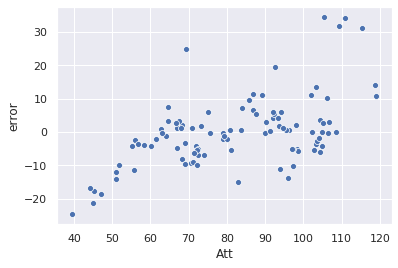

In [132]:
sns.scatterplot(x='Att',y='error',data=y)